In [2]:
## Steps

## Import models
## Load Image and Preprocess Image
## Split the data into train and test
## Build the model
## Finding accuracy
## Prediction
## Visulizing the model
## Save the model



## Import Libraries

In [3]:
import numpy as np
import pandas as pa
import cv2
import gc
import os
import seaborn as sn 
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D,MaxPooling2D,Dropout,Flatten,Dense,Input
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from imutils import paths
import tensorflow as tf
import warnings 
warnings.filterwarnings('ignore')

In [1]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16177600225417982470,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5077532672
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 978556890862680438
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:25:00.0, compute capability: 6.1"]

### Model Pipeline

In [2]:
class ModelPipeLine:
    def __init__(self,path=None):
        self.path = path
    
    def test_image_preprocess(self,path):
        self.path = path
        images,labels,label_encoder = self.__load_image()
        return images,labels,label_encoder
    
    def __load_image(self):
        all_images = []
        labels = []
        
        all_images_files = list(paths.list_images(self.path))
        #print(all_images_files)
        for image_file in all_images_files:
            try:
                image = cv2.imread(image_file)
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image = cv2.resize(image,(256,256))
                all_images.append(image)

                label = image_file.split(os.path.sep)[-2]
                labels.append(label)
            except:
                print("ERROR LOADING IMAGE")
        
        all_images = np.array(all_images)/255.0
        labels = np.array(labels)
        
        #print(all_images)
        #print(labels)
        
        label_encoder = LabelEncoder()
        encoded_label = label_encoder.fit_transform(labels)
        labels = to_categorical(encoded_label)
        
        return all_images,labels,label_encoder
    
    def train_inceptionv3(self):
        
        lr = 1e-5  
        epochs = 50 
        batchsize = 8
        
        images,labels,_ = self.__load_image()
        
        (trainX,testX,trainY,testY) = train_test_split(images,labels,test_size=0.20,stratify=labels,random_state=42)
        
        ## Load the inceptionV3 model
        basemodel = InceptionV3(weights='imagenet',include_top=False,input_tensor=Input(shape=(256,256,3)))
        headmodel = basemodel.output
        headmodel = AveragePooling2D(pool_size=(4, 4))(headmodel)
        headmodel = Flatten(name="flatten")(headmodel)
        headmodel = Dense(64, activation="relu")(headmodel)
        headmodel = Dropout(0.5)(headmodel)
        headmodel = Dense(3, activation="softmax")(headmodel)

        model = Model(inputs=basemodel.input,outputs=headmodel)
        
        print("Compiling model...")
        opt = Adam(lr=lr, decay=lr / epochs)
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
        model.summary()
        
        trainaugment =  ImageDataGenerator(rotation_range=15, fill_mode="nearest")
        
        H = model.fit_generator( trainaugment.flow(trainX, trainY, batch_size=batchsize), steps_per_epoch=len(trainX) // batchsize,
                         validation_data=(testX, testY), validation_steps=len(testX) // batchsize, epochs=epochs)
        
        self.__save_model(model)
    
    ## Not Yet Completed
    def train_vgg19(self):
        pass
    
    def train_restnet50(self):
        pass
    
    def __save_model(self,model):
        model.save('D:/Models/covid_model_final.h5')
        

### Train the Model

In [ ]:
path = "C:/Users/BABI/Covid19-X-Rays-master/all/train"
train_1 = ModelPipeLine(path)
train_1.train_inceptionv3()

In [ ]:
del train_1
gc.collect()

### Load The Trained Model

In [4]:
model = tf.keras.models.load_model('D:/Models/covid_model.h5')

### Model for checking the test dataset accuracy

In [4]:
class Test_Model:
    def __init__(self,path):
        BS = 8
        test_obj = ModelPipeLine()
        test_images,labels_test,label_encoder = test_obj.test_image_preprocess(path)
        
        predTest = model.predict(test_images, batch_size=BS)
        print(predTest)
        predClasses = predTest.argmax(axis=-1)
        print(predClasses)
        print("Evaluating real test samples ...")

        testX = test_images
        testY = labels_test

        predIdxs = model.predict(testX, batch_size=BS)
        predIdxs = np.argmax(predIdxs, axis=1)


        print(classification_report(testY.argmax(axis=1), predIdxs,
            target_names=label_encoder.classes_))

        cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
        total = sum(sum(cm))
        acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
        sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
        specificity = (cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]) / (cm[1, 0] + cm[1, 1] + cm[1, 2] + cm[2, 0] + cm[2, 1] + cm[2, 2])

        print(cm)
        print("acc: {:.4f}".format(acc))
        print("sensitivity: {:.4f}".format(sensitivity))
        print("specificity: {:.4f}".format(specificity))

### Test the data

In [5]:
test_ = Test_Model('C:/Users/BABI/Covid19-X-Rays-master/all/test')

[[9.7659063e-01 2.2820769e-02 5.8865314e-04]
 [9.9840420e-01 2.9527312e-04 1.3004891e-03]
 [9.9273819e-01 3.8089780e-03 3.4527865e-03]
 [4.0290105e-01 2.1799172e-03 5.9491909e-01]
 [9.9883395e-01 8.1448967e-04 3.5162823e-04]
 [9.9955517e-01 1.0432238e-04 3.4043696e-04]
 [9.9432290e-01 2.4692898e-03 3.2078174e-03]
 [9.9891698e-01 5.1982304e-05 1.0309705e-03]
 [9.9450928e-01 8.8259956e-04 4.6081496e-03]
 [1.0585950e-03 9.8656625e-01 1.2375197e-02]
 [1.4145529e-02 7.8911167e-01 1.9674285e-01]
 [6.3940405e-04 2.2523463e-01 7.7412593e-01]
 [1.7382699e-04 9.9591488e-01 3.9112777e-03]
 [1.0733237e-04 9.4475830e-01 5.5134412e-02]
 [2.9796815e-02 7.2831142e-01 2.4189174e-01]
 [1.8055111e-05 9.4480848e-01 5.5173505e-02]
 [1.6443661e-05 9.9771297e-01 2.2705686e-03]
 [8.5260933e-03 9.7560674e-01 1.5867261e-02]
 [2.6607955e-05 4.2202327e-04 9.9955136e-01]
 [6.0503711e-03 7.1785448e-04 9.9323177e-01]
 [2.2053523e-02 3.7031441e-03 9.7424328e-01]
 [4.6245628e-03 2.3133113e-04 9.9514413e-01]
 [2.547690

### Neural Net Visualization (GRAD CAM)

In [20]:
class Neural_Visuals:
    def __init__(self,image_path,GRAD_CAM = True):
        file = image_path
        self.image_original = cv2.imread(file)
        plt.imshow(self.image_original)
        plt.show()
        
        self.orig = cv2.cvtColor(self.image_original, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(self.orig, (256, 256))
        dataXG = np.array(resized) / 255.0
        dataXG = np.expand_dims(dataXG, axis=0)
        
        preds = model.predict(dataXG)
        i = np.argmax(preds[0])
        print(i, preds)
        
        if GRAD_CAM == True:
            self.grad_cam_visulaization(dataXG,i)
        
    def grad_cam_visulaization(self,dataXG,i):
        cam = GradCAM(model=model, classIdx=i, layerName='mixed10')
        heatmap = cam.compute_heatmap(dataXG)
        plt.imshow(heatmap)
        plt.show()
        
        heatmapY = cv2.resize(heatmap, (self.orig.shape[1], self.orig.shape[0]))
        heatmapY = cv2.applyColorMap(heatmapY, cv2.COLORMAP_HOT)  # COLORMAP_JET, COLORMAP_VIRIDIS, COLORMAP_HOT
        imageY = cv2.addWeighted(heatmapY, 0.5, self.image_original, 1.0, 0)
        print(heatmapY.shape, self.orig.shape)# draw the orignal x-ray, the heatmap, and the overlay together
        #output = np.hstack([self.orig, heatmapY, imageY])
        #fig, ax = plt.subplots(figsize=(20, 18))
        #ax.imshow(np.random.rand(1, 99), interpolation='nearest')
        plt.imshow(imageY)
        plt.show()
    
    ## Soon
    def grad_cam_plusplus_visulaization(self):
        pass


In [18]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            
        
        grads = tape.gradient(loss, convOutputs)
        
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        return heatmap

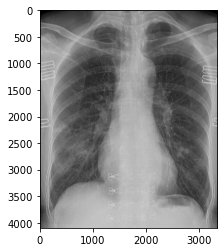

0 [[9.9883395e-01 8.1449084e-04 3.5162823e-04]]


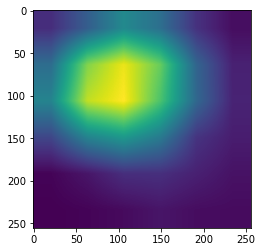

(4095, 3342, 3) (4095, 3342, 3)


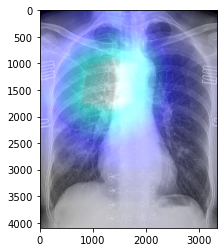

In [21]:
neural_v = Neural_Visuals('C:/Users/BABI/Covid19-X-Rays-master/all/test/covid/ryct.2020200028.fig1a.jpeg')